In [1]:
!pip install opencv-python

Upload your kaggle API key to download HAM10000 dataset

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"davydnaveriani","key":"6800da770ceb850b7ae035d7b29c671d"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle


In [4]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
Dataset URL: https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip -d skin_cancer_data
!unzip ham1000-segmentation-and-classification.zip -d ham1000-segmentation-and-classification

In [6]:
!pip install segmentation-models-pytorch --quiet
!pip install albumentations --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 134.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.0 MB/s eta 0:00:00


In [7]:
import os
import shutil

import time
import copy

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms import ToTensor, CenterCrop, Normalize
from torchvision.transforms.functional import to_pil_image, to_tensor, resize
from torchvision.transforms.functional import normalize
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import random_split
from torchvision.transforms import v2
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

from PIL import Image
from tempfile import TemporaryDirectory

In [8]:
os.makedirs("skin_cancer_data/images", exist_ok=True)

shutil.rmtree("skin_cancer_data/ham10000_images_part_1")
shutil.rmtree("skin_cancer_data/ham10000_images_part_2")
shutil.rmtree("ham1000-segmentation-and-classification/images")
os.remove("ham1000-segmentation-and-classification/GroundTruth.csv")

for folder in ["HAM10000_images_part_1", "HAM10000_images_part_2"]:
  src = os.path.join("skin_cancer_data", folder)
  for file in os.listdir(src):
    shutil.move(os.path.join(src, file), 'skin_cancer_data/images')
  shutil.rmtree(os.path.join("skin_cancer_data", folder))

shutil.move("ham1000-segmentation-and-classification/masks", 'skin_cancer_data/masks')

'skin_cancer_data/masks'

In [9]:
IMAGE_DIR = "skin_cancer_data/images"
MASK_DIR = "skin_cancer_data/masks"

In [10]:
df = pd.read_csv("skin_cancer_data/HAM10000_metadata.csv")
df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


In [11]:
df["dx"].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [12]:
df["image_id"] = df["image_id"] + ".jpg"

In [13]:
folder_path = images_dir = "skin_cancer_data/images"
file_count = len([f for f in os.listdir(images_dir)])
file_count

10015

Distribution of classes in Dataset

<ipython-input-14-17cf7ffcaaee>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='label', order=df['label'].value_counts().index, palette='Set2')
<ipython-input-14-17cf7ffcaaee>:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='label', loc='center left', bbox_to_anchor=(1, 0.5))


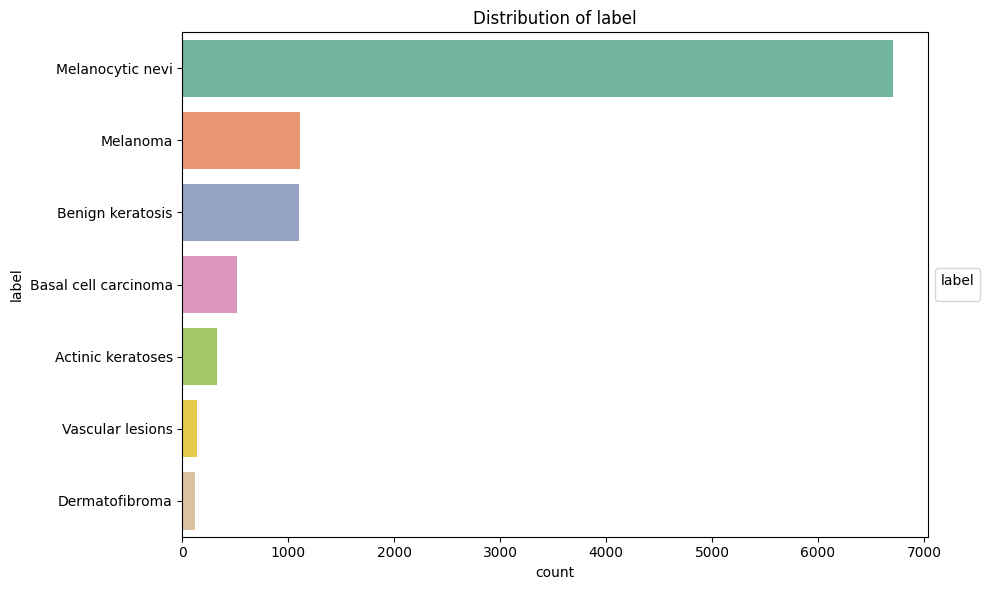

In [14]:
label_map = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}

df["label"] = df["dx"].map(label_map)

plt.figure(figsize=(10,6))
sns.countplot(data=df, y='label', order=df['label'].value_counts().index, palette='Set2')
plt.xlabel('count')
plt.ylabel('label')
plt.title('Distribution of label')
plt.legend(title='label', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


Implementation of function to remove the noise (hair and etc) from the skin image

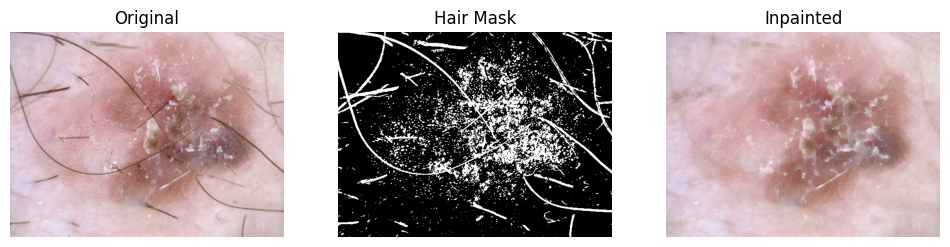

In [77]:
def dull_razor(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    inpainted = cv2.inpaint(image, mask, 1, cv2.INPAINT_TELEA)

    return inpainted, mask

img = cv2.imread('skin_cancer_data/images/ISIC_0033084.jpg')

result, hair_mask = dull_razor(img)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Hair Mask"); plt.imshow(hair_mask, cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("Inpainted"); plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()


In [16]:
class HAM10000Segmentation(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace(".jpg", "_segmentation.png"))

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = (mask > 0).astype("float32")

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].unsqueeze(0)

        return image, mask


In [21]:
transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

dataset_seg = HAM10000Segmentation(IMAGE_DIR, MASK_DIR, transform=transform)
train_dataset_seg, test_dataset_seg = torch.utils.data.random_split(dataset_seg, [0.8, 0.2])
train_loader_seg = torch.utils.data.DataLoader(train_dataset_seg, batch_size=64, shuffle=True)
test_loader_seg = torch.utils.data.DataLoader(test_dataset_seg, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(encoder_name="resnet34", in_channels=3, classes=1)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [22]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader_seg:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader_seg)}")


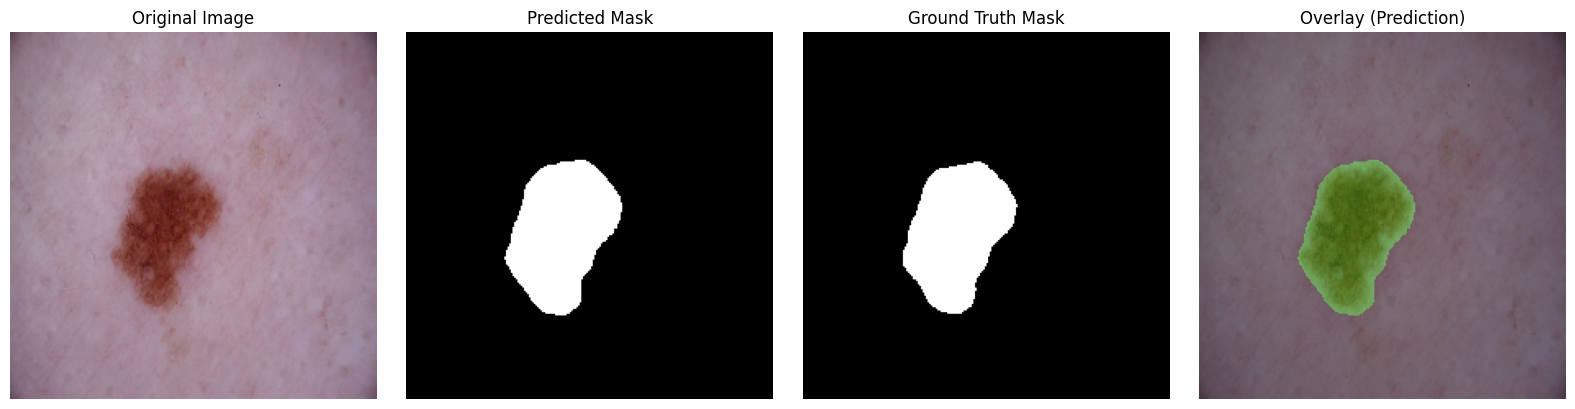

In [78]:
def denormalize(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
     for t, m, s in zip(tensor, mean, std):
         t.mul_(s).add_(m)
     return tensor

def visualize_prediction_vs_truth(model, dataset, index=0, device="cuda", threshold=0.3, overlay=True):
     model.eval()

     image, true_mask = dataset[index]
     input_tensor = image.unsqueeze(0).to(device)

     with torch.no_grad():
         output = model(input_tensor)  # (1, 1, H, W)
         output = torch.sigmoid(output)
         pred_mask = output[0, 0].cpu().numpy()  # (H, W)
         pred_mask_bin = (pred_mask > threshold).astype(np.float32)

     denorm_image = denormalize(image.clone())  # (3, H, W)
     image_np = to_pil_image(denorm_image.cpu())
     true_mask_np = true_mask.squeeze().cpu().numpy()

     overlay_image = np.array(image_np).copy()
     if overlay:
         overlay_mask = (pred_mask_bin * 255).astype(np.uint8)
         colored = np.stack([overlay_mask * 0, overlay_mask, overlay_mask * 0], axis=-1)
         overlay_image = np.clip(overlay_image * 0.7 + colored * 0.3, 0, 255).astype(np.uint8)

     plt.figure(figsize=(16, 4))

     plt.subplot(1, 4, 1)
     plt.imshow(image_np)
     plt.title("Original Image")
     plt.axis("off")

     plt.subplot(1, 4, 2)
     plt.imshow(pred_mask_bin, cmap="gray")
     plt.title("Predicted Mask")
     plt.axis("off")

     plt.subplot(1, 4, 3)
     plt.imshow(true_mask_np, cmap="gray")
     plt.title("Ground Truth Mask")
     plt.axis("off")

     plt.subplot(1, 4, 4)
     plt.imshow(overlay_image)
     plt.title("Overlay (Prediction)")
     plt.axis("off")

     plt.tight_layout()
     plt.show()

visualize_prediction_vs_truth(
     model=model,
     dataset=test_dataset_seg,
     index=1,
     device=device,
     threshold=0.3
)


Define custom PyTorch Dataset class, split dataset into train and test. Create two Dataloaders for each of them

In [37]:
annotations_file = "skin_cancer_data/HAM10000_metadata.csv"
images_dir = "skin_cancer_data/images"

label_map = {
    'akiec': 0,
    'bcc': 1,
    'bkl': 2,
    'df': 3,
    'mel': 4,
    'nv': 5,
    'vasc': 6
}


class ClearHair(torch.nn.Module):
    def forward(self, img):
        img_np = np.array(img)
        new_image, _ = dull_razor(img_np)
        return Image.fromarray(new_image)


class SegmentAndTransform:
    def __init__(self, seg_model, device, image_size=(224, 224)):
        self.seg_model = seg_model
        self.device = device
        self.image_size = image_size
        self.seg_model.eval()

    def __call__(self, img):
        img_resized = resize(to_tensor(img), self.image_size).unsqueeze(0).to(self.device)
        with torch.no_grad():
            output = self.seg_model(img_resized)
            mask = torch.sigmoid(output)[0, 0]
            mask_bin = (mask > 0.3).float()

        img_tensor = img_resized.squeeze(0) * mask_bin

        img_tensor = normalize(img_tensor,
                               mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])

        return img_tensor



class HAM10000(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
      df = pd.read_csv(annotations_file)[["image_id", "dx"]]
      df["image_id"] = df["image_id"] + ".jpg"
      df["dx"] = df["dx"].map(label_map)
      self.labels = df
      self.img_dir = img_dir
      self.transform = transform
      self.target_transform = target_transform

  def __len__(self):
      return len(self.labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
    image = Image.open(img_path).convert("RGB")
    label = self.labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label


transforms = v2.Compose([
    ClearHair(),
    SegmentAndTransform(model, device),
])


dataset = HAM10000(annotations_file, images_dir, transform=transforms)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

index_to_class = {v: k for k, v in label_map.items()}

train_labels = [train_dataset.dataset.labels.iloc[i, 1] for i in train_dataset.indices]

class_sample_counts = np.bincount(train_labels)

class_weights = 1/class_sample_counts
sample_weights = [class_weights[label] for label in train_labels]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, sampler=sampler, drop_last=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=0)

unique_class_ids = sorted(set(train_labels))

class_names = [index_to_class[i] for i in unique_class_ids]
class_names



['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

Set cuda is available

Define a train function

In [38]:
train_size = len(train_dataset)
test_size = len(test_dataset)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  loss_train = []
  loss_test = []
  acc_train = []
  acc_test = []

  for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs}")
    print("-"*20)

    model.train()

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(True):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size

    loss_train.append(epoch_loss)
    acc_train.append(epoch_acc)
    print(f"Train Loss: {epoch_loss}, Acc: {epoch_acc}")

    ### Validation mode
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)


      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)


      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / test_size
    epoch_acc = running_corrects.double() / test_size
    loss_test.append(epoch_loss)
    acc_test.append(epoch_acc)

    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Test Loss: {epoch_loss}, Acc: {epoch_acc}")
  time_elapsed = time.time() - since
  print(f"Training Complete in {time_elapsed}")
  print(f"Best validation accuracy {best_acc}")
  model.load_state_dict(best_model_wts)
  return model, loss_train, loss_test, acc_train, acc_test

Load pre-trained ResNet-18 for fine-tuning

In [39]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 238MB/s]


Model training

In [40]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


def run_training(model_ft, criterion, optimizer_ft, exp_lr_scheduler):
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                           num_epochs=10)
    return model_ft

model_ft, loss_train, loss_test, acc_train, acc_test = run_training(model_ft, criterion, optimizer_ft, exp_lr_scheduler)


Epoch 0/10
--------------------
Train Loss: 0.8217513112502877, Acc: 0.6928357463804294
Test Loss: 1.364016444815199, Acc: 0.47728407388916627
Epoch 1/10
--------------------
Train Loss: 0.4336712244922259, Acc: 0.827009485771343
Test Loss: 1.6379905239796555, Acc: 0.4702945581627559
Epoch 2/10
--------------------
Train Loss: 0.3130773481463291, Acc: 0.871193210184723
Test Loss: 0.8415541398900185, Acc: 0.6874687968047929
Epoch 3/10
--------------------
Train Loss: 0.23830657736158822, Acc: 0.902521218172741
Test Loss: 1.02555512739192, Acc: 0.63554667998003
Epoch 4/10
--------------------
Train Loss: 0.20127252239735793, Acc: 0.919995007488767
Test Loss: 1.0435777646091897, Acc: 0.7034448327508738
Epoch 5/10
--------------------
Train Loss: 0.16485721399590067, Acc: 0.9333499750374439
Test Loss: 0.9920937342460431, Acc: 0.6560159760359461
Epoch 6/10
--------------------
Train Loss: 0.12786728003830894, Acc: 0.9449575636545183
Test Loss: 1.162321893441576, Acc: 0.7209186220668997
Epoc

Learning Curves Visualisation

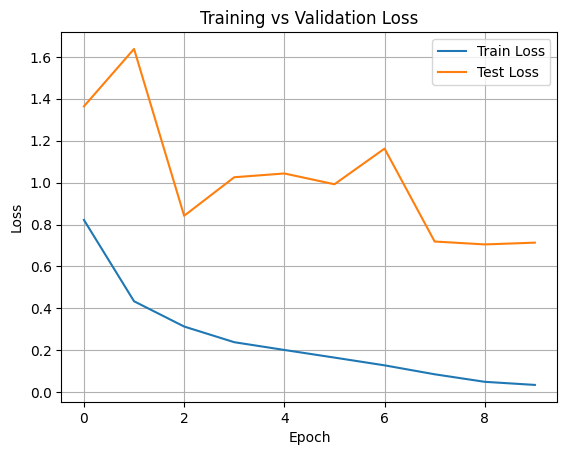

In [52]:
epochs = list(range(len(loss_train)))

plt.plot(epochs, loss_train, label="Train Loss")
plt.plot(epochs, loss_test, label="Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


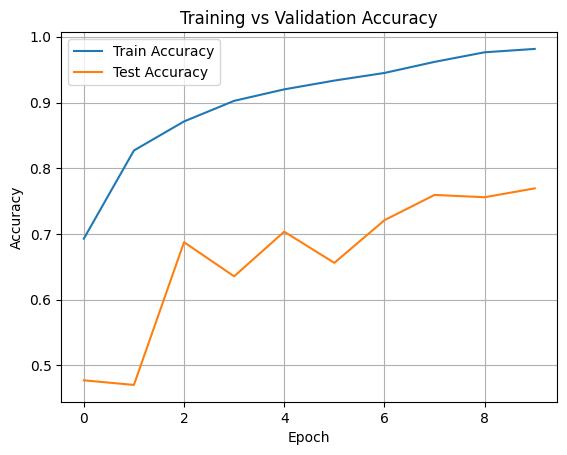

In [42]:
epochs = list(range(len(loss_train)))

acc_train = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in acc_train]
acc_test = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in acc_test]

plt.plot(epochs, acc_train, label="Train Accuracy")
plt.plot(epochs, acc_test, label="Test Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
torch.save(model_ft.state_dict(), "сlassification_model.pth")

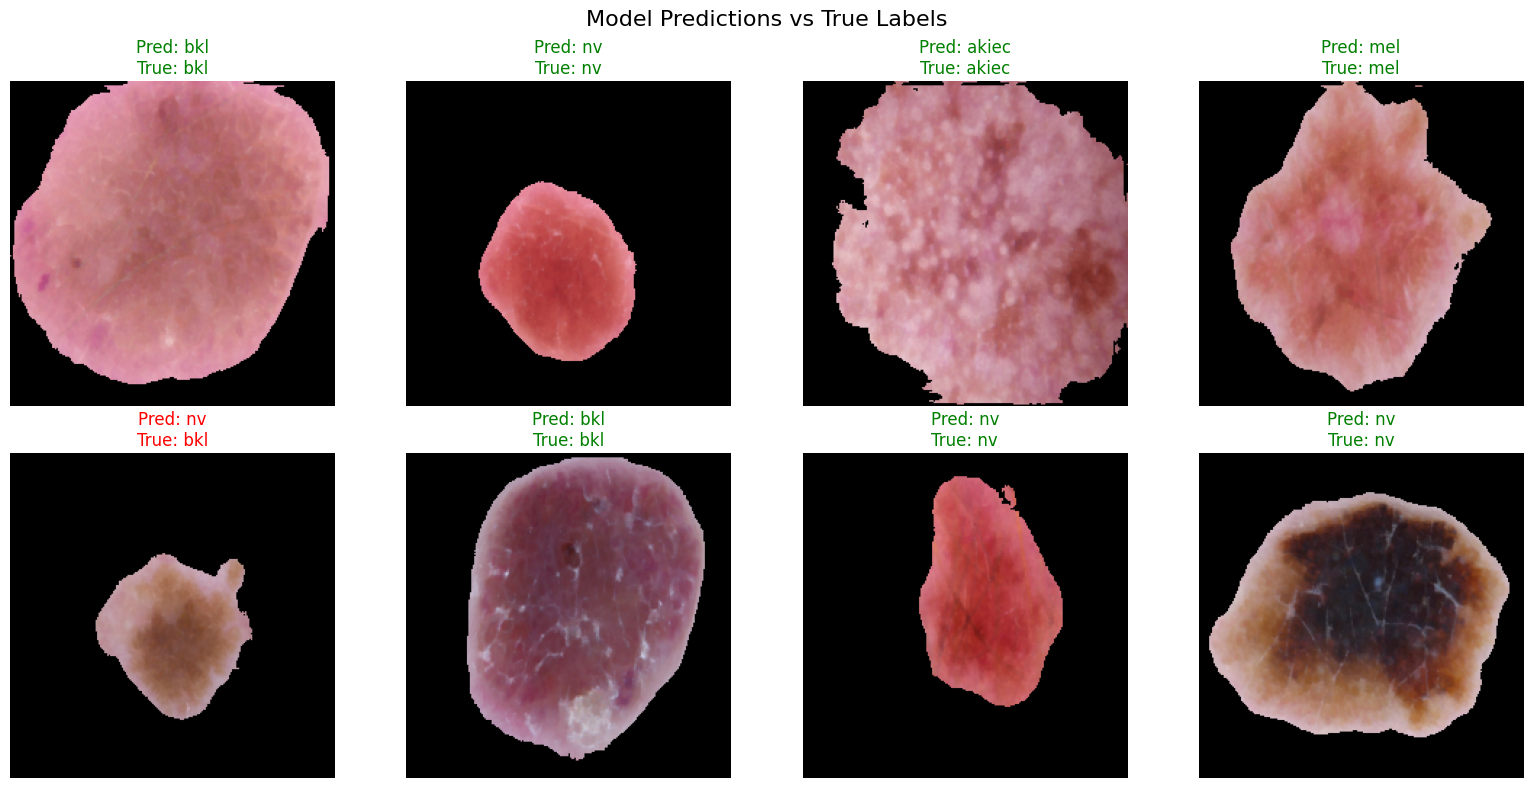

In [79]:
import matplotlib.pyplot as plt

model_ft.eval()

class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

def imshow_tensor(img_tensor):
    img = img_tensor.cpu().clone()
    img = img.numpy().transpose((1, 2, 0))
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")

inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(16, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    imshow_tensor(inputs[i])
    ax.set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}", color=("green" if preds[i] == labels[i] else "red"))
plt.suptitle("Model Predictions vs True Labels", fontsize=16)
plt.tight_layout()
plt.show()
